## <b><span style='color:#4148f7'>|</span> SUMÁRIO

1. [Introdução](#1--introduzindo-o-problema)
    
    1.1 [Importando as bibliotecas e os dados](#11--importando-as-bibliotecas-e-os-dados)

2. [Análise exploratória e tratamentos](#2--análise-exploratória-e-tratamento)

    2.1[Análise exploratória](#21--análise-exploratória)

    2.2[Tratamentos](#22--tratamentos)

3. [Analisando as correlações](#3--analisando-as-correlações)

4. [Machine Learning](#4--machine-learning)

    4.1 [Dividindo os dados de treino e teste](#41--dividindo-os-dados-de-treino-e-teste)

    4.2 [Aplicando o modelo de regressão linear](#42--aplicando-o-modelo-de-regressão-linear)

    4.3 [Aplicando o modelo de árvore de decisão](#43--aplicando-o-modelo-de-árvore-de-decisão)

    4.4 [Aplicando o random forest](#44--aplicando-random-forest)
    
    4.5 [Automatizando tudo com uma pipeline personalizada](#45--automatizando-tudo-com-uma-pipeline-personalizada)

5. [Aplicando o gridsearch no melhor modelo](#5--aplicando-o-gridsearchcv-no-melhor-modelo)

6. [Salvando o modelo final](#6--salvando-o-modelo-final)


## <b>1. <span style='color:#4148f7'>|</span> INTRODUZINDO O PROBLEMA

Nesse estudo de caso, iremos utilizar Machine Learning para prever preços medianos de casas no estado da California (EUA).

Para isso, iremos trabalhar com 3 tipos de modelos de regressão (linear, árvore de decisão e floresta aleatória), sendo que iremos aplicar a técnica de validação cruzada para (obviamente) validar os modelos e depois iremos automatizar parte do processo com uma pipeline personalizada. Por fim, otimizaremos o modelo de melhor desempenho a partir da busca por melhores parâmetros com o GridSearchCV. 

A principal métrica que iremos utilizar para avaliar o nosso modelo é a Raiz Quadrada do Erro Quarático Médio (RMSE), uma métrica bastante utilizada em modelos de regressão que basicamente nos mostra se nossas previsões apresentam um erro alto em relação a média ou não. 

Para ajudar quem está começando, farei tudo de forma comentada.

 -- Nota: normalmente, nos casos em que o que queremos prever ("Y"/"Variável Dependente") é um número (como os preços de imóveis), o ponto de partida em ML são os modelos de Regressão. Em outros casos, como por exemplo na predição de categorias (ex: problemas de detecção de imagem) ou no agrupamento de amostras (ex: segmentação de clientes), aplicam-se outros tipos de modelos de aprendizagem, como os modelos de classificação e de clusterização, que irei abordar em outro momento. 

### <b>1.1 <span style='color:#4148f7'>|</span> IMPORTANDO AS BIBLIOTECAS E OS DADOS

In [1]:
## Abaixo estão todas as bibliotecas que iremos utilizar ao longo do projeto. Se você não as tem baixada, é só fazer o "pip install" no seu terminal.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler

import gc
import pickle



In [2]:
## Os dados são oriundos do github do autor do livro "Hands on Machine Learning With Scikit-Learn, Keras & Tensor Flow",
## mas também podem ser encontrados no Kaggle buscando por "california house pricing".
## também vou deixar disponível no meu github. 

url_csv = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(url_csv)

## <b>2. <span style='color:#4148f7'>|</span> ANÁLISE EXPLORATÓRIA E TRATAMENTO

### <b>2.1 <span style='color:#4148f7'>|</span> ANÁLISE EXPLORATÓRIA

In [3]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Antes de mais nada, aqui está a descrição das colunas:

1. longitude: uma medida do quão distante do Meridiano de Greenwich a casa está; quanto menor for, mais próximo do oeste a casa se encontra.
2. latitude: uma medida do quão distante do Equador a casa está; quanto maior for, mais próximo do norte a casa se encontra.
3. housing_median_age: a mediana de idade das casas em um quarteirão. Quanto menor, mais novas são as residências.
4. total_rooms: número total de cômodos em um quarteirão.
5. total_bedrooms: número total de quartos em um quarteirão.
6. population: número total de pessoas residindo em um quarteirão.
7. households: número total de grupos de moradores de uma mesma residência em um quarteirão (semelhante a famílias em um quarteirão).
8. median_income: renda mediana dos grupos de moradores em um mesmo quarteirão de casas (medidos em 10 mil dólares)
9. median_house_value: valor mediano das casas dos grupos de moradores em um mesmo quarteirão (medido em dólares)
10. ocean_proximity: localização da casa em relação ao mar/oceano.

In [4]:
## Vamos ver algumas informações do dataframe.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Nossa primeira observação é que a coluna "total_bedrooms" possui alguns nulos. 

Podemos tratar isso de diversas formas, mas as mais comuns são:

1. substituir os nulos pela média ou pela mediana da coluna (o que pode trazer melhores resultados quando condicionamos a média/mediana a certas condições);
2. substituir os nulos por zero (nem sempre recomendado, mas funciona bem quando temos dados categóricos e queremos criar uma categoria de nulos).
3. apagar as informações (também não é muito recomendado e geralmente só é aplicado quando são poucas observações em relação ao total dos dados, assim a perca de informação não causa um impacto muito relevante na base);
4. aplicar modelos preditivos para prever os valores nulos (que é o que vamos fazer mais pra frente neste caso);


In [5]:
## Agora vamos ver um resumo estatístico das variáveis numéricas.

df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


Nada demais até aqui.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

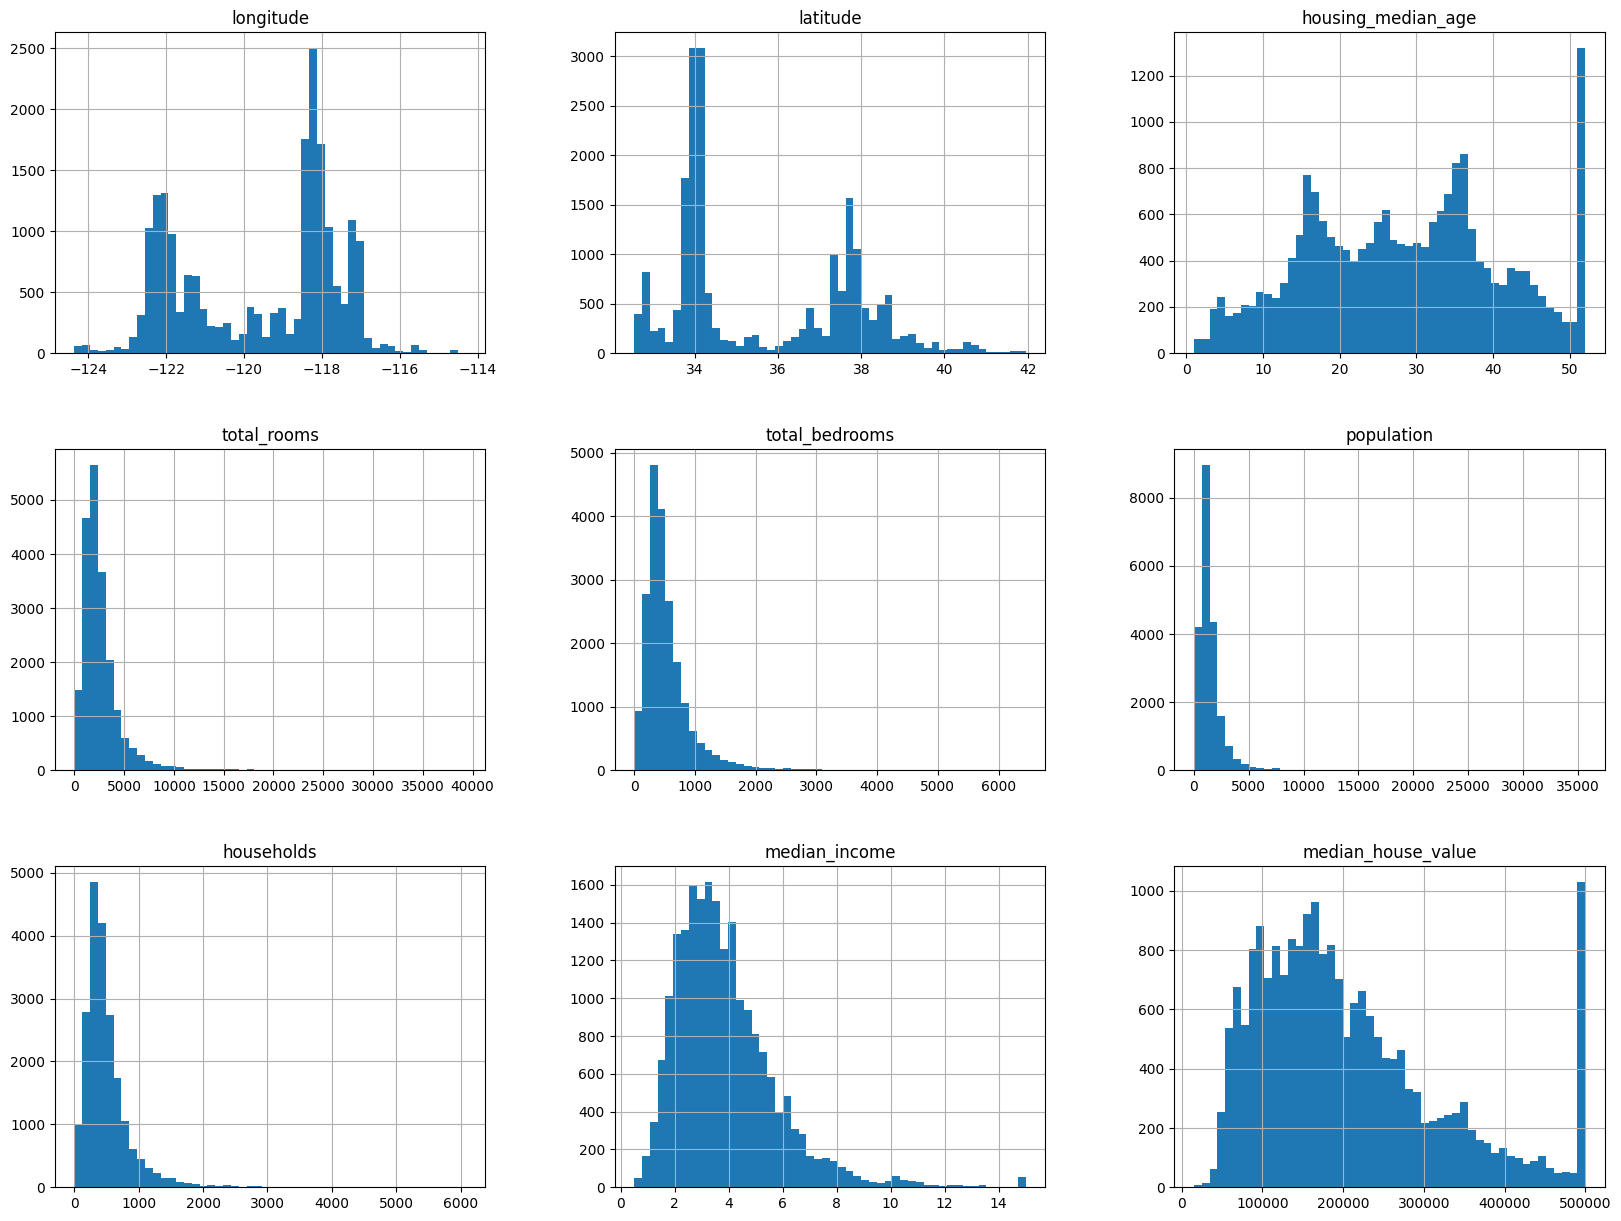

In [6]:
##Outra coisa legal é aplicar um histograma para rapidamente ver a distribuição dos dados.

df.hist(bins=50, figsize=(20,15))

Com esse quadro podemos observar que a maioria das features não seguem uma distribuição próxima da normal e suas escalas são diferentes, o que pode ser tratado para melhorar o modelo. Além disso, as colunas de preço e idade mediano(a) das casas aparentam terem sido cortadas, o que não pode ser resolvido por si só, mas pode ser considerado no modelo a partir de dummies.

### <b>2.2 <span style='color:#4148f7'>|</span> TRATAMENTOS

#### <b>2.2.1 <span style='color:#4148f7'>|</span> MELHORANDO A DISTRIBUIÇÃO DOS DADOS NUMÉRICOS

In [7]:
## Vamos começar nossos tratamentos criando categorias para a renda média porque ela está muito concentrada. 
## Isso vai ser útil quando formos dividir os dados em treino e teste pra previsão.

df['income_cat'] = pd.cut(df['median_income'],
                          bins = [0., 1.5, 3, 4.5, 6., np.inf],
                          labels = [1, 2, 3, 4, 5])
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


<Axes: >

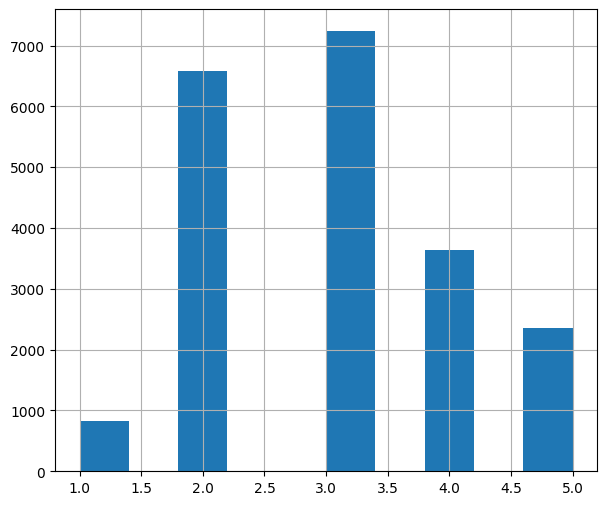

In [8]:
df['income_cat'].hist(figsize=(7,6))

In [9]:
## Agora vamos pegar todas as colunas que não seguem a distribuição normal e aplicar o logarítimo para tentar normalizá-las.

var_desbal = ['households', 'median_income' ,'population', 'total_bedrooms', 'total_rooms']
log_var_numericas = []
for i in var_desbal:
    df[i + '_log'] = np.log1p(df[i])
    log_var_numericas.append(i + '_log')

df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,households_log,median_income_log,population_log,total_bedrooms_log,total_rooms_log
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,4.844187,2.232720,5.777652,4.867534,6.781058
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,7.037906,2.230165,7.784057,7.009409,8.867850
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,5.181784,2.111110,6.208590,5.252273,7.291656
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.393628,1.893579,6.326149,5.463832,7.150701
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,5.560682,1.578195,6.338594,5.638355,7.395108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2,5.802118,0.940124,6.740519,5.926926,7.418181
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2,4.744932,1.268861,5.877736,5.017280,6.548219
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2,6.073045,0.993252,6.915723,6.186209,7.720905
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2,5.857933,1.053336,6.609349,6.016157,7.528869


array([[<Axes: title={'center': 'households_log'}>,
        <Axes: title={'center': 'median_income_log'}>],
       [<Axes: title={'center': 'population_log'}>,
        <Axes: title={'center': 'total_bedrooms_log'}>],
       [<Axes: title={'center': 'total_rooms_log'}>, <Axes: >]],
      dtype=object)

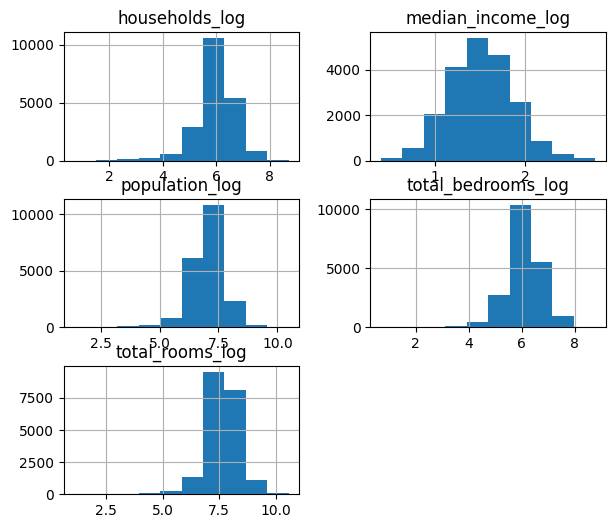

In [10]:
df[log_var_numericas].hist(figsize=(7,6))

Repare como nossas distribuições melhoraram consideravelmente.

#### <b>2.2.2 <span style='color:#4148f7'>|</span> CRIANDO DUMMIES

In [11]:
## Agora, vamos inserir dummies para detectar observações com valores "clipados" (limítofres) da coluna house_median_age, com distribuição próxima da normal.

max_house_age = df['housing_median_age'].max()
df['age_clipped'] = df['housing_median_age'] == max_house_age

In [12]:
df[df['housing_median_age']==max_house_age]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,households_log,median_income_log,population_log,total_bedrooms_log,total_rooms_log,age_clipped
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,5.181784,2.111110,6.208590,5.252273,7.291656,True
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.393628,1.893579,6.326149,5.463832,7.150701,True
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,5.560682,1.578195,6.338594,5.638355,7.395108,True
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3,5.267858,1.616771,6.025866,5.365976,6.824374,True
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,3,6.244167,1.538822,6.998510,6.194405,7.838343,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20142,-119.06,34.36,52.0,1239.0,320.0,934.0,298.0,1.8618,183300.0,<1H OCEAN,2,5.700444,1.051451,6.840547,5.771441,7.122867,True
20220,-119.27,34.28,52.0,2239.0,420.0,941.0,397.0,4.1250,349000.0,NEAR OCEAN,3,5.986452,1.634131,6.848005,6.042633,7.714231,True
20236,-119.27,34.27,52.0,459.0,112.0,276.0,107.0,2.3750,198400.0,NEAR OCEAN,2,4.682131,1.216395,5.624018,4.727388,6.131226,True
20237,-119.27,34.27,52.0,1577.0,343.0,836.0,335.0,3.5893,206600.0,NEAR OCEAN,3,5.817111,1.523728,6.729824,5.840642,7.363914,True


In [13]:
## Vamos também tratar a colunas categórica de proximidade do oceano criando dummies para cada categoria. 

df = pd.get_dummies(df, columns=['ocean_proximity'])


OBS: Poderíamos tratar essa coluna criando apenas uma coluna com um valor numérico pra cada categoria existente. Porém, as dummies são mais recomendadas neste caso porque as nossas categorias não possuem uma ordem proporcional de valor entre si. Logo, se criássemos apenas uma nova coluna com valores ordenados (ex: 1, 2, 3, 4 e 5) para cada categoria, não é verdade que o 2 seria o dobro de 1, nem o 3 o triplo, e etc. Isso é subjetivo neste caso. Então, para evitar que nosso modelo interprete isso errado, optei pelas dummies.

In [14]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,...,median_income_log,population_log,total_bedrooms_log,total_rooms_log,age_clipped,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5,...,2.232720,5.777652,4.867534,6.781058,False,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5,...,2.230165,7.784057,7.009409,8.867850,False,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5,...,2.111110,6.208590,5.252273,7.291656,True,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4,...,1.893579,6.326149,5.463832,7.150701,True,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,...,1.578195,6.338594,5.638355,7.395108,True,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2,...,0.940124,6.740519,5.926926,7.418181,False,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2,...,1.268861,5.877736,5.017280,6.548219,False,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2,...,0.993252,6.915723,6.186209,7.720905,False,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2,...,1.053336,6.609349,6.016157,7.528869,False,0,1,0,0,0


#### <b>2.2.3 <span style='color:#4148f7'>|</span> SUBSTITUINDO NULOS COM REGRESSÃO LINEAR (UM TIPO DE MACHINE LEARNING)

In [15]:
## Agora vamos passar para a etapa de substituição dos nulos da coluna total_bedrooms e da coluna total_bedrooms_log.

df.corr()['total_bedrooms'].sort_values(ascending=False)

C:\Users\Marcilio Duarte\AppData\Local\Temp\ipykernel_32844\755513991.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['total_bedrooms'].sort_values(ascending=False)


total_bedrooms                1.000000
households                    0.979728
total_rooms                   0.930380
population                    0.877747
total_bedrooms_log            0.812971
households_log                0.787492
total_rooms_log               0.760280
population_log                0.723306
longitude                     0.069608
median_house_value            0.049686
ocean_proximity_<1H OCEAN     0.018314
median_income_log             0.017837
ocean_proximity_NEAR OCEAN    0.000679
ocean_proximity_ISLAND       -0.004361
ocean_proximity_INLAND       -0.006463
median_income                -0.007723
ocean_proximity_NEAR BAY     -0.019873
latitude                     -0.066983
age_clipped                  -0.081759
housing_median_age           -0.320451
Name: total_bedrooms, dtype: float64

In [16]:
df.corr()['total_bedrooms_log'].sort_values(ascending=False)

C:\Users\Marcilio Duarte\AppData\Local\Temp\ipykernel_32844\3443192998.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['total_bedrooms_log'].sort_values(ascending=False)


total_bedrooms_log            1.000000
households_log                0.974593
total_rooms_log               0.945865
population_log                0.897523
total_bedrooms                0.812971
households                    0.805072
total_rooms                   0.744873
population                    0.716395
longitude                     0.060817
median_house_value            0.053311
ocean_proximity_<1H OCEAN     0.041725
ocean_proximity_NEAR OCEAN    0.016429
median_income_log             0.014404
ocean_proximity_ISLAND       -0.001902
ocean_proximity_NEAR BAY     -0.016793
median_income                -0.025575
ocean_proximity_INLAND       -0.044914
latitude                     -0.068248
age_clipped                  -0.094013
housing_median_age           -0.272112
Name: total_bedrooms_log, dtype: float64

Com esse primeiro comando da correlação, identificamos que as correlações acima de 0,7 (fortes) são:

**total_bedrooms:**

- households                    0.979728
- total_rooms                   0.930380
- population                    0.877747
- total_bedrooms_log            0.812971
- households_log                0.787492
- total_rooms_log               0.760280
- population_log                0.723306

 
**total_bedrooms_log:**

- households_log                0.974593
- total_rooms_log               0.945865
- population_log                0.897523
- total_bedrooms                0.812971
- households                    0.805072
- total_rooms                   0.744873
- population                    0.716395

Note que as variáveis total_rooms, households e population estão aparecendo em formato comum e com log. Elas são correlacionadas porque o valor de uma deriva da outra. Assim como total_bedrooms_log deriva de total_bedrooms. Sob risco de multicolinearidade, não podemos incluir essas variáveis no modelo simultaneamente. Será que há também uma forte correlação das variáveis entre si? Vamos investigar.

<Axes: >

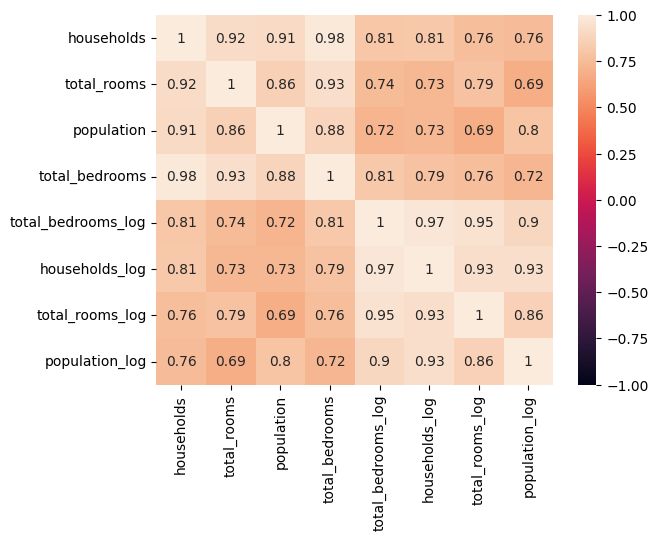

In [17]:
sns.heatmap(df[['households', 'total_rooms', 'population','total_bedrooms', 'total_bedrooms_log', 'households_log', 'total_rooms_log', 'population_log']].corr(), vmin=-1, vmax=1, annot=True)

Como esperado, existe alta correlação entre as variáveis.

Arbitrariamente, vou selecionar a variável com maior correlação com aquela que queremos prever e as variáveis que apresentam correlação inferior a 0,8 com esta variável. Portanto, as escolhidas para prever total_bedrooms são: households, total_rooms_log e population_log.Já para total_bedrooms_log são: households_log, total_rooms, population.

In [18]:
## Para prever os valores nulos, primeiro precisamos separar nossos dados nulos dos não nulos. 
## Nos não nulos faremos o fit e o treino e nos dados nulos aplicaremos o teste.

df_notnull = df.copy().dropna()
df_null = df[df['total_bedrooms'].isnull()]

In [19]:
## Agora, vamos dividir os dados de treino e teste:

x1_train = df_notnull[['households', 'total_rooms_log', 'population_log']]
x2_train = df_notnull[['households_log', 'total_rooms', 'population']]
x1_test = df_null[['households', 'total_rooms_log', 'population_log']]
x2_test = df_null[['households_log', 'total_rooms', 'population']]

In [20]:
y1_train = df_notnull[['total_bedrooms']]
y2_train = df_notnull[['total_bedrooms_log']]
y1_test = df_null[['total_bedrooms']]
y2_test = df_null[['total_bedrooms_log']]

In [21]:
## Feito isso, vamos fitar os modelos:

lr1 = LinearRegression()
lr1.fit(x1_train, y1_train)
lr2 = LinearRegression()
lr2.fit(x2_train,y2_train)

LinearRegression()

In [22]:
## Aplicando os modelos:

y1_train_pred = lr1.predict(x1_train)
y1_pred = lr1.predict(x1_test)
y2_train_pred = lr2.predict(x2_train)
y2_pred = lr2.predict(x2_test)

In [23]:
## Avaliando os modelos:

print('Como o modelo está prevendo dados nulos, avaliar o resultado final é impossível. Não temos como saber o erro de algo nulo.\nMas podemos avaliar a partir dos dados de treino\n')
print(f'O erro médio absoluto do treino do modelo 1 foi:', mean_absolute_error(y1_train, y1_train_pred).round(2),'e o r2 foi:', r2_score(y1_train, y1_train_pred).round(2))
print('\n')
print(f'Já no segundo modelo, O erro médio absoluto do treino foi:', mean_absolute_error(y2_train, y2_train_pred).round(2), 'e o r2 foi:', r2_score(y2_train, y2_train_pred).round(2))


Como o modelo está prevendo dados nulos, avaliar o resultado final é impossível. Não temos como saber o erro de algo nulo.
Mas podemos avaliar a partir dos dados de treino

O erro médio absoluto do treino do modelo 1 foi: 40.27 e o r2 foi: 0.96


Já no segundo modelo, O erro médio absoluto do treino foi: 0.08 e o r2 foi: 0.95


In [24]:
## Por fim, substituimos os valores:

df_null['total_bedrooms'] = y1_pred
df_null['total_bedrooms_log'] = y2_pred

C:\Users\Marcilio Duarte\AppData\Local\Temp\ipykernel_32844\3045352990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['total_bedrooms'] = y1_pred
C:\Users\Marcilio Duarte\AppData\Local\Temp\ipykernel_32844\3045352990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['total_bedrooms_log'] = y2_pred


In [25]:
## Como deu tudo certo, vamos unir os dados novamente em um só dataframe.

df = pd.concat(objs=[df_null, df_notnull], axis=0)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,...,median_income_log,population_log,total_bedrooms_log,total_rooms_log,age_clipped,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
290,-122.16,37.77,47.0,1256.0,247.517015,570.0,218.0,4.3750,161900.0,3,...,1.681759,6.347389,5.480267,7.136483,False,0,0,0,1,0
341,-122.17,37.75,38.0,992.0,258.490056,732.0,259.0,1.6196,85100.0,2,...,0.963022,6.597146,5.621572,6.900731,False,0,0,0,1,0
538,-122.28,37.78,29.0,5154.0,1351.966291,3741.0,1273.0,2.5762,173400.0,2,...,1.274301,8.227376,7.138008,8.547722,False,0,0,0,1,0
563,-122.24,37.75,45.0,891.0,173.777785,384.0,146.0,4.9489,247100.0,4,...,1.783206,5.953243,5.100027,6.793466,False,0,0,0,1,0
696,-122.10,37.69,41.0,746.0,177.386295,387.0,161.0,3.9063,178400.0,3,...,1.590520,5.961005,5.184777,6.616065,False,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.000000,845.0,330.0,1.5603,78100.0,2,...,0.940124,6.740519,5.926926,7.418181,False,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.000000,356.0,114.0,2.5568,77100.0,2,...,1.268861,5.877736,5.017280,6.548219,False,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.000000,1007.0,433.0,1.7000,92300.0,2,...,0.993252,6.915723,6.186209,7.720905,False,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.000000,741.0,349.0,1.8672,84700.0,2,...,1.053336,6.609349,6.016157,7.528869,False,0,1,0,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 290 to 20639
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   longitude                   20640 non-null  float64 
 1   latitude                    20640 non-null  float64 
 2   housing_median_age          20640 non-null  float64 
 3   total_rooms                 20640 non-null  float64 
 4   total_bedrooms              20640 non-null  float64 
 5   population                  20640 non-null  float64 
 6   households                  20640 non-null  float64 
 7   median_income               20640 non-null  float64 
 8   median_house_value          20640 non-null  float64 
 9   income_cat                  20640 non-null  category
 10  households_log              20640 non-null  float64 
 11  median_income_log           20640 non-null  float64 
 12  population_log              20640 non-null  float64 
 13  total_bedrooms

In [27]:
## Vamos liberar espaço da memória agora.

del df_notnull, 
df_null, 
x1_train, 
x2_train,
x1_test, 
x2_test, 
y1_train, 
y1_test, 
y2_train, 
y2_test, 
lr1, 
lr2, 
y1_train_pred, 
y1_pred, 
y2_train_pred, 
y2_pred
gc.collect()

100

Ok, nulos substituídos com regressão linear!

Lembrando que poderíamos tratá-los de outra forma sem ter todo esse trabalho. Inclusive, pelo fato de não ter como avaliar a previsão de um dado nulo, muitas vezes aplicar modelos preditivos não é o melhor caminho. 

OBS: mais pra frente vamos aplicar o modelo de regressão linear novamente, mas de forma mais "profissional". Por enquanto, isso basta.

#### <b>2.2.4 <span style='color:#4148f7'>|</span> CRIANDO NOVAS VARIÁVEIS (FEATURE ENGINEERING)

In [28]:
## Nossas novas variáveis serão:

df['rooms_per_household_log'] = np.log1p(df['total_rooms']/df['households'])
df['bedroms_per_room_log'] = np.log1p(df['total_bedrooms']/df['total_rooms'])
df['housing_population_log'] = np.log1p(df['population']/df['households'])

## Nota: o termo feature engineering (engenharia de atributos) é o nome gourmetizado para a criação de variáveis.

#### <b>2.2.5 <span style='color:#4148f7'>|</span> PADRONIZANDO A ESCALA DAS VARIÁVEIS NUMÉRICAS

In [29]:
## Por fim, vamos tratar a escala das colunas numéricas, exceto a coluna que queremos prever.

num_attributes = df[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'income_cat', 'households_log', 'median_income_log', 'population_log', 'total_bedrooms_log', 'total_rooms_log', 'age_clipped']].columns


<Axes: >

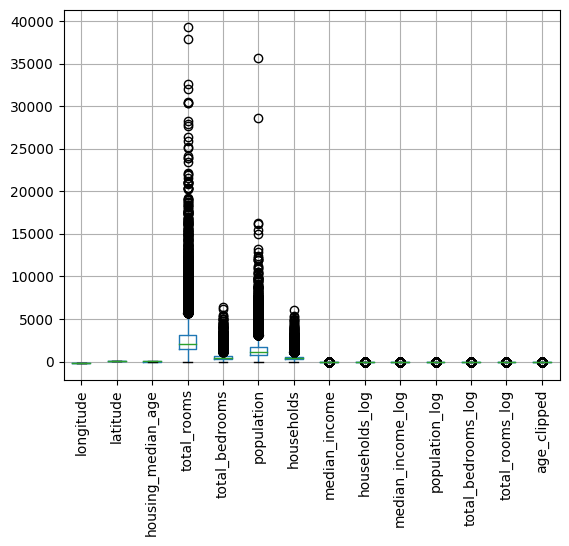

In [30]:
## Antes de aplicar a transformação, vamos ver o boxplot dos dados que iremos transformar.
df[num_attributes].boxplot(rot=90)

<Axes: >

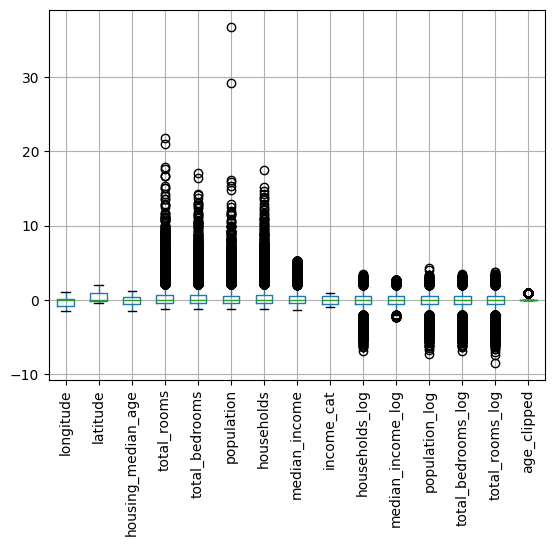

In [31]:
transformer = RobustScaler()
transformer.fit(df[num_attributes])
df[num_attributes] = transformer.transform(df[num_attributes])
df[num_attributes].boxplot(rot=90)

Comparando os dois boxplots é possível enxergar que, apesar dos outliers se manterem, a maior parte dos dados ficou concentrada dentro do intervalo de -2 e 2, que é o que o Robust Scaler faz. 

Enfim, feito tudo isso, terminamos os tratamentos!

Vamos aproveitar que estamos simulando uma situação real e exportar os dados tratados em .parquet para um novo diretório.
Em projetos com equipes múltiplas, geralmente adota-se essa boa prática. 

In [32]:
df.to_parquet(r'C:\Users\Marcilio Duarte\OneDrive\Documents\Projetos\6 - Awari_DS\02_tarefas\projeto_final\data_science\house_prices\data\clean\calif_housing_prices_clean.parquet')

OBS: os arquivos .parquet são muito utilizados para armanezar dados pois ocupam espaço menor do que o .csv, por exemplo.

E já que citei situações reais, outro fato interessante é que nesses casos geralmente as etapas que aplicaremos abaixo são feitas em outro código/notebook. Assim, quem estiver trabalhando na parte de elaboração do modelo poderia importar os dados já tratados e fazer suas análises em um código/notebook separado, sem ter que executar todo o tratamento novamente. Além disso, uma parte da equipe pode iniciar a aplicação de modelos e etc antes mesmo do tratamento ficar pronto para já ter um norte quando os dados tratados forem disponibilizados. 

## <b> 3. <span style = 'color:#4148f7'>|</span> ANALISANDO AS CORRELAÇÕES

In [2]:
## Ler  o arquivo parquet no pandas é bem semelhante à leitura do csv. Veja:

df = pd.read_parquet(r'C:\Users\Marcilio Duarte\OneDrive\Documents\Projetos\6 - Awari_DS\02_tarefas\projeto_final\data_science\house_prices\data\clean\calif_housing_prices_clean.parquet')

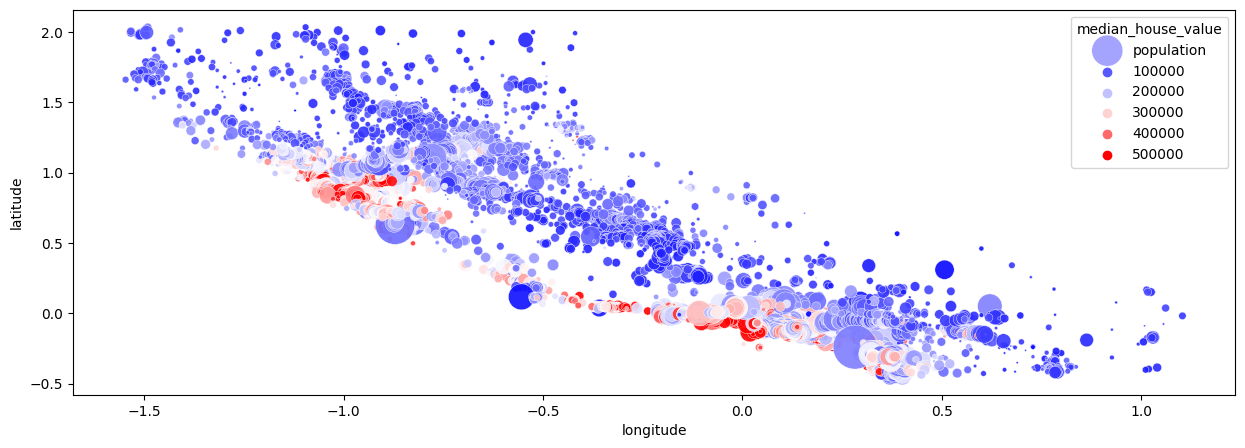

In [34]:
## Vamos analisar nossos dados graficamente colocando cores de acordo com a mediana de preço das casas e pontos de acordo com o tamanho da população.
color_palette = sns.color_palette('bwr', as_cmap=True)

## Definindo a faixa de tamanhos dos pontos do gráfico com base na coluna de população.
size_range = (1, 1000)
point_sizes = np.interp(df['population'], (df['population'].min(), df['population'].max()), size_range)

## Criando o gráfico
fig = plt.figure(figsize=(15,5))
ax = sns.scatterplot(data=df, x='longitude', y='latitude', alpha=0.9,
           s=point_sizes, label='population',
           palette=color_palette, hue=df['median_house_value'])
plt.show()

Com essa visualização é possível perceber que o preço das casas é mais caro nas regiões de Los Angeles e São Francisco, como era de se esperar.
Além disso, há alguns aglomerados populacionais em várias regiões, como em Santa Bárbara.

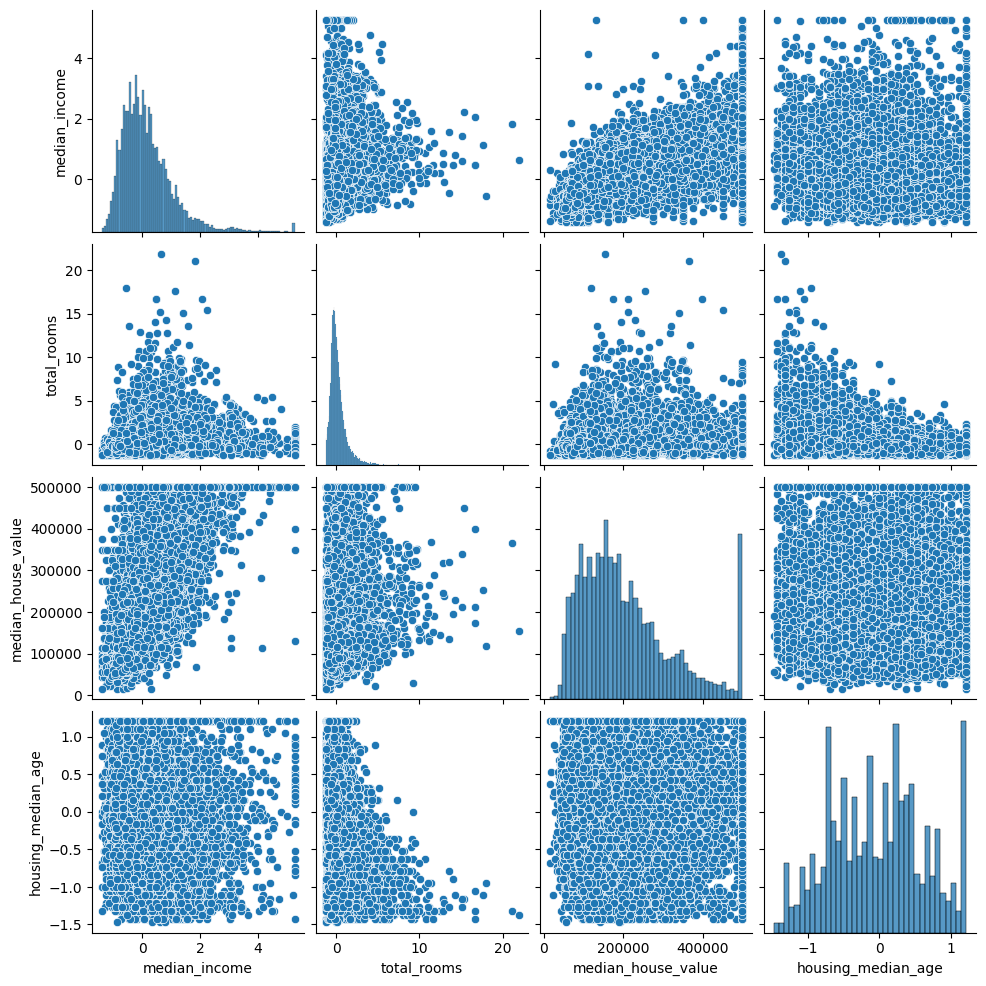

In [35]:
## Agora vamos gerar uma visualização da correlação entre alguns atributos com o seaborn.

attributes = ['median_income', 'total_rooms', 'median_house_value', 'housing_median_age']
sns.pairplot(df[attributes])

Há uma correlação entre a renda média e o preço mediano das casas, como era de se esperar também.

<Axes: xlabel='median_income', ylabel='median_house_value'>

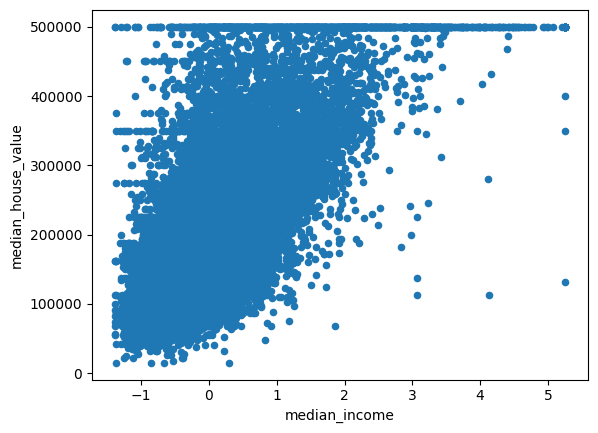

In [36]:
## Para ver melhor a afirmação acima.

df.plot(kind='scatter', x ='median_income', y='median_house_value')

In [37]:
## Agora vamos verificar a correlação entra as variáveis e o preço médio das casas.

df.corr()['median_house_value'].round(2).sort_values(ascending=False)


median_house_value            1.00
median_income                 0.69
median_income_log             0.67
income_cat                    0.64
ocean_proximity_<1H OCEAN     0.26
rooms_per_household_log       0.24
ocean_proximity_NEAR BAY      0.16
total_rooms_log               0.16
age_clipped                   0.15
ocean_proximity_NEAR OCEAN    0.14
total_rooms                   0.13
housing_median_age            0.11
households                    0.07
households_log                0.07
total_bedrooms                0.05
total_bedrooms_log            0.05
ocean_proximity_ISLAND        0.02
population                   -0.02
population_log               -0.02
longitude                    -0.05
latitude                     -0.14
housing_population_log       -0.25
bedroms_per_room_log         -0.27
ocean_proximity_INLAND       -0.48
Name: median_house_value, dtype: float64

<Axes: >

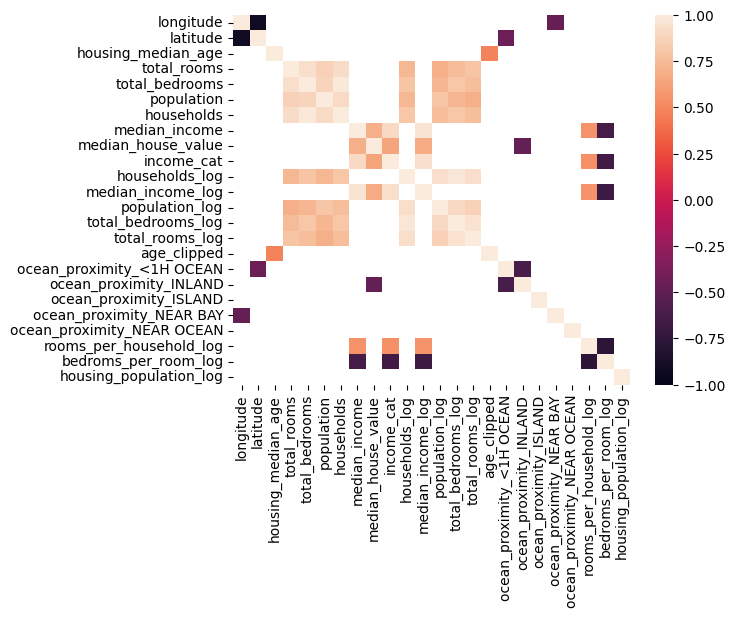

In [38]:
## Feito isso, vamos analisar a matriz de correlação dos dados como um todo a fim de identificar variáveis explicativas correlacionadas entre si.

cmatrix = df.corr().round(2)
cmatrix_filter = cmatrix[(cmatrix>0.4) | (cmatrix<-0.4)]
sns.heatmap(cmatrix_filter, vmin=-1, vmax=1)

Bom, as variáveis mais correlacionadas com o preço médio da casa são aquelas referente à renda média das pessoas e a dummie ocean_proximity_inland, que apresentam um grau de correlação moderado. Fora elas, temos apenas variáveis com correlação fraca. 

Neste caso, seguirei com as variáveis normalizadas e com a variável de renda média não normalizada para as próximas etapas. Não irei dropar variáveis pouco correlacionadas porque iremos utilizar modelos que apresentam melhor perfomance quando com mais variáveis explicativas, mas poderíamos seguir por esse caminho também. 


OBS: 

1. Em muitos casos, principalmente naqueles em que se aplica a regressão linear, usa-se apenas a análise da matriz de correlação para escolher as variáveis do modelo. Nestes casos, selecionamos variáveis com correlação forte em relação a variável dependente e não correlacionadas entre si. Isso é útil para reduzir a dimensionalidade e evitar erros de multicolinearidade/overfitting. Lembrando que a correlação é maior quanto mais próxima de 1 ou -1. 

2. Há alguns debates sobre a partir de qual valor deve-se considerar uma correlação forte, mais a maioria dos autores adota valores maiores do que 0,7 ou menores do que -0,7 como base. Valores entre 0,2 (-0,2) e 0,39 (-0,39) são considerados correlação fraca, entre 0,4 (-0,4) e 0,69 (-0,69) correlação moderada 

## <b> 4. <span style = 'color:#4148f7'>|</span> MACHINE LEARNING

### <b> 4.1 <span style = 'color:#4148f7'>|</span> DIVIDINDO OS DADOS DE TREINO E TESTE

In [39]:
## Separando as variáveis para o modelo.
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'income_cat', 'households_log',
       'median_income_log', 'population_log', 'total_bedrooms_log',
       'total_rooms_log', 'age_clipped', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'rooms_per_household_log', 'bedroms_per_room_log',
       'housing_population_log'],
      dtype='object')

In [3]:
## Armazenando o dataframe que iremos utilizar para a previsão em uma nova variável.

df1 = df[['longitude', 'latitude', 'housing_median_age','median_income',
           'median_house_value', 'households_log','population_log', 'total_bedrooms_log', 'total_rooms_log',
            'rooms_per_household_log','bedroms_per_room_log', 'housing_population_log',
            'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
            'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
            'ocean_proximity_NEAR OCEAN',
            'income_cat', 'age_clipped']]

In [4]:
## Vamos separar os dados em 70% treino e 30% teste. Outro método utilizado costuma ser 80/20. 
## Utilizaremos o parâmetro random_state para fixar os valores que serão separados sempre que o código for executado.
## Outro parâmetro é o stratify, que é utilizado para preservar variáveis desbalanceadas de forma balanceada nos grupos de treino e teste.

train, test = train_test_split(df1, 
                               random_state=42,
                               test_size=0.3,
                               stratify=df['income_cat'])

In [42]:
## Vamos ver se deu certo.

train

,longitude,latitude,housing_median_age,median_income,median_house_value,households_log,population_log,total_bedrooms_log,total_rooms_log,rooms_per_household_log,bedroms_per_room_log,housing_population_log,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_cat,age_clipped
8148,0.108179,-0.119048,-0.473684,1.868752,402500.0,0.986391,0.861441,0.981990,1.397159,2.104441,0.138760,1.287144,1,0,0,0,0,1.0,0.0
5799,0.065963,-0.034392,0.842105,0.989655,269000.0,-0.048497,-0.142051,-0.104069,0.025767,1.872973,0.169568,1.293962,1,0,0,0,0,0.5,0.0
4634,0.050132,-0.050265,-0.052632,-0.757804,300000.0,2.285670,2.053998,2.254321,1.156255,1.162914,0.395133,1.241264,1,0,0,0,0,-0.5,0.0
15366,0.348285,-0.243386,-0.736842,-0.337730,189900.0,0.417252,-0.167967,0.569693,0.570560,1.927763,0.186438,1.033916,1,0,0,0,0,-0.5,0.0
9687,-0.825858,0.656085,0.052632,0.689313,165400.0,-0.654147,-0.420860,-0.692562,-0.597651,1.858320,0.173306,1.479947,1,0,0,0,0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13490,0.292876,-0.052910,-0.631579,-0.081519,112300.0,0.301728,0.412797,0.343512,0.501093,1.957745,0.166588,1.416831,0,1,0,0,0,0.0,0.0
14642,0.340369,-0.388889,0.263158,-0.139276,192200.0,-0.792408,-1.334119,-0.918211,-1.329567,1.483854,0.246901,1.044628,0,0,0,0,1,0.0,0.0
15534,0.364116,-0.296296,-1.000000,-0.040966,190500.0,0.458059,0.228521,0.485962,0.529090,1.873651,0.180866,1.222865,1,0,0,0,0,0.0,0.0
5497,0.021108,-0.068783,0.052632,-0.157717,271200.0,0.995283,1.485060,0.977884,0.659528,1.616233,0.233568,1.657795,1,0,0,0,0,0.0,0.0


In [5]:
## Deu certo. Agora vamos dropar a coluna que criamos para fazer a estratificação dos dados da renda.

train.drop(columns=['income_cat'], inplace=True)
test.drop(columns=['income_cat'], inplace=True)

In [6]:
## Primeiro, vamos separar a variável dependente das explicativas para ambos os conjuntos (treino e teste).

y_train = train['median_house_value']
x_train = train.drop(columns='median_house_value')

y_test = test['median_house_value']
x_test = test.drop(columns='median_house_value')

### <b> 4.2 <span style = 'color:#4148f7'>|</span> APLICANDO O MODELO DE REGRESSÃO LINEAR

In [37]:
## Feito isso, vamos agora criar um objeto para inicializar a classe e fitar o modelo.

lreg = LinearRegression()
lreg.fit(x_train, y_train)

LinearRegression()

Quando aplicamos o método fit, o que está acontecendo nos bastidores é que o algoritmo está buscando os melhores valores para 
a constante e os parâmetros de inclinação da equação. Ele faz isso avaliando o erro do modelo e optando pelo que apresenta menor erro. 

OBS: o fit sempre é aplicado aos dados de treino!

In [38]:
## Com o modelo "fitado", vamos fazer uma previsão.

yHat_lreg = lreg.predict(x_test)

In [39]:
## Tendo os valores previstos, vamos fazer uma comparação com os valores reais.

y_test.head(10)

17957    287600.0
17003    270100.0
7234     145500.0
2543      92700.0
10018    213300.0
8170     250700.0
3943     251500.0
10462    275900.0
10854    275000.0
5305     500001.0
Name: median_house_value, dtype: float64

In [40]:
yHat_lreg[:10]

array([292981.01905185, 270841.83789437, 117059.13785705, 201486.24359245,
       182035.80815692, 269711.65010386, 283922.91200936, 272298.36666006,
       303094.3654894 , 475721.01793439])

In [41]:
## É possível observar que os valores previstos ficaram relativamente longe dos valores reais. Vamos confirmar isso com uma métrica.

lreg_rmse_test = np.sqrt(mean_squared_error(y_test, yHat_lreg))
lreg_rmse_test

64603.47523158937

In [42]:
print(f'O erro do modelo de teste é de U$',lreg_rmse_test.round(2),'.')

O erro do modelo de teste é de U$ 64603.48 .


In [43]:
## Vamos ver o mesmo para o modelo de treino.

lreg_y_hat_train = lreg.predict(x_train)
lreg_rmse_train = np.sqrt(mean_squared_error(y_train, lreg_y_hat_train))
print(f'O erro do modelo de treino é de U$',lreg_rmse_train.round(2),'.')

O erro do modelo de treino é de U$ 65252.86 .


Até que o erro foi menor do que eu estava esperando, mas ainda assim, imagine que uma casa de 200K doláres pode ter seu valor estimado entre cerca de 137 mil ou 263 mil. É uma faixa muito grande. Por isso, vamos tentar melhorar o modelo utilizando a validação cruzada, se não mudar muita coisa, vamos testar outros modelos, começando pela Árvore de Decisão. 

#### <b> 4.2.1 <span style = 'color:#4148f7'>|</span> VALIDANDO A REGRESSÃO LINEAR COM CROSS-VALIDATION

O cross-validation divide nossos dados de treino em X amostras e aplica X vezes o modelo escolhido. Ele faz isso alternando alguns grupos de dados para conjunto de treino e outro para teste/validação entre as X subdivisões que foram determinadas pelo parâmetro cv. 

Ex: Com 10 subdivisões, ele usa primeiro os grupos de 1 a 9 para treinar e o 10 para testar. Depois, ele usa o conjunto de 2 a 10 para treinar e o 1 para prever. E assim por diante. Ao final, ele armazena o valor do score selecionado para cada teste realizado, de forma que seja possível tirar uma média para conferir de forma mais precisa a qualidade do modelo estimado a fim de validar os nossos resultados de treino.

In [44]:
cvscores_lreg = cross_val_score(lreg, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
cv_lreg_rmse = np.sqrt(-cvscores_lreg) 
print(np.mean(cv_lreg_rmse).round(2))
print(np.std(cv_lreg_rmse).round(2))



65513.87
1556.56


Repare que os resultados do cross validation foram parecidos com o do modelo de treino, o que indica que não foi uma aleatoriedade.

### <b> 4.3 <span style = 'color:#4148f7'>|</span> APLICANDO O MODELO DE ÁRVORE DE DECISÃO

In [45]:
## Feito isso, a lógica é a mesma do modelo anterior. Criar o objeto com a classe e depois fitar os dados de treino.

dtreg = DecisionTreeRegressor()
dtreg.fit(x_train,y_train)

DecisionTreeRegressor()

In [46]:
## Com os dados de treino fitados, vamos agora aplicar o modelo.

y_hat_train_dtreg = dtreg.predict(x_train)

In [47]:
## Vamos ver o erro.

dtreg_rmse_train = np.sqrt(mean_squared_error(y_train, y_hat_train_dtreg))
print(f'O erro do modelo de treino é de U$',dtreg_rmse_train.round(2),'.')

O erro do modelo de treino é de U$ 0.0 .


Bizarro né, a árvore se adaptou perfeitamente ao modelo de treino e o ERRO FOI 0! Isso pode ser um perigo caso ela não generalize bem para os dados de teste. Vamos verificar!

In [48]:
y_hat_test_dtreg = dtreg.predict(x_test)
dtreg_rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test_dtreg))
print(f'O erro do modelo de teste é de U$',dtreg_rmse_test.round(2),'.')

O erro do modelo de teste é de U$ 70596.75 .


O erro foi ainda maior do que o do modelo de regressão linear. Logo, avaliando apenas essa métrica, de cara podemos descartar esse modelo. Além disso, como esperado, ele está sofrendo do chamado "Overfitting". Ele está se ajustando muito aos valores de treino, mas os valores de teste (do erro) estão altos e descolados do ideal. Na prática, isso é um sintoma de um modelo mal generalizado, ou seja, um modelo que não se aplica bem a dados "novos".

#### <b> 4.3.1 <span style = 'color:#4148f7'>|</span> VALIDANDO A ÁRVORE DE DECISÃO COM CROSS-VALIDATION

In [49]:
## Agora, vamos aplicar a validação cruzada aos dados de treino dividindo-os em 10 amostras.

cvscores_dtreg = cross_val_score(dtreg, x_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [50]:
## Como não há a nossa métrica no scoring, vamos calculá-la manualmente.

cv_dtreg_rmse = np.sqrt(-cvscores_dtreg)
cv_dtreg_rmse

array([70900.83204699, 69417.95968402, 72149.34653036, 73072.94007248,
       67561.33697214, 70735.3136215 , 70214.69770464, 76659.99415141,
       69281.47481097, 68740.9963667 ])

In [51]:
## É possível observar de cara que os valores continuaram muito altos. Vamos calcular a média e o desvio padrão deles.

print(np.mean(cv_dtreg_rmse).round(2))
print(np.std(cv_dtreg_rmse).round(2))


70873.49
2461.18


Os resultados do modelo de RL continuam melhores do que os do modelo de árvore de decisão. Portanto, até então, este deve ser o modelo adotado. Porém, ainda há alternativas para testar, afinal sabemos que o erro continua alto para o problema que estamos buscando resolver. Portanto, a seguir iremos conhecer o Random Forest.

### <b> 4.4 <span style = 'color:#4148f7'>|</span> APLICANDO RANDOM FOREST

In [52]:
rfreg = RandomForestRegressor()

In [53]:
## Fazendo o fit.

rfreg.fit(x_train,y_train)

RandomForestRegressor()

In [54]:
## Criando a previsão para o conjunto de treino.

rfreg_yhat_train = rfreg.predict(x_train) 

In [55]:
## Calculando o erro para o conjunto de treino.

rfreg_rmse_train = np.sqrt(mean_squared_error(y_train, rfreg_yhat_train)).round(2)
rfreg_rmse_train

18639.67

In [56]:
## Repetindo para o conjunto de teste.

y_hat_test_rfreg = rfreg.predict(x_test)
rfreg_rmse_test = np.sqrt(mean_squared_error(y_test, y_hat_test_rfreg))
print(f'O erro do modelo de teste é de U$',rfreg_rmse_test.round(2),'.')

O erro do modelo de teste é de U$ 50000.11 .


#### <b> 4.4.1 <span style = 'color:#4148f7'>|</span> VALIDANDO O RANDOM FOREST COM CROSS-VALIDATION

In [57]:
cvscores_rfreg = cross_val_score(rfreg, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
cvscores_rfreg

array([-2.52753132e+09, -2.60556664e+09, -2.49762702e+09, -2.55591075e+09,
       -2.36443592e+09, -2.49299955e+09, -2.65640143e+09, -2.43271883e+09,
       -2.59233882e+09, -2.42205249e+09])

In [58]:
cv_rmse_rfreg = np.mean(np.sqrt(-cvscores_rfreg)).round(2)
cv_std_rfreg = np.std(np.sqrt(-cvscores_rfreg)).round(2)

print('A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$', cv_rmse_rfreg)
print('O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$', cv_std_rfreg)

A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$ 50139.93
O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$ 863.77


O modelo de Random Forest funcionou muito bem. Reduzimos o erro em cerca de U$ 15K e o desvio padrão entre os resultados do cross-validation foi baixo. Portanto, adotaremos este modelo, mas ainda podemos melhorá-lo ajustando alguns parâmetros com o GridSearch! Antes disso, porém, vamos introduzir um facilitador de vidas: o pipeline.  

### <b> 4.5. <span style = 'color:#4148f7'>|</span> AUTOMATIZANDO TUDO COM UMA PIPELINE PERSONALIZADA

Como você deve ter observado, o processo é o mesmo para os diferentes modelos. Depois que os dados são divididos em treino e teste, faz-se o fit, a predição e a avaliação. Logo, podemos criar funções que automatizem boa parte do processo para nós. Essas funções são chamadas de pipelines.

In [59]:
## Primeiro, vamos criar nossas funções.

def get_train_test(data, ts=0.3, rs=42, stratify='income_cat', target='median_house_value'):
  train, test = train_test_split(data, 
                                 random_state=rs,
                                 test_size=ts,
                                 stratify = df[stratify])
  train.drop(columns=[stratify], inplace=True)
  test.drop(columns=[stratify], inplace=True)
  y_train = train[target]
  x_train = train.drop(columns=target)
  y_test = test[target]
  x_test = test.drop(columns=target)
  return x_train, x_test, y_train, y_test

def model_apply(model, x_train, y_train, x_test):
  model.fit(x_train, y_train)
  yHat = model.predict(x_test)
  return yHat

def evaluate_model(y_test, yHat, modelo):
  print(f'Avaliando o modelo {modelo}:')
  print('\n')
  rmse = np.sqrt(mean_squared_error(y_test, yHat)).round(2)
  r2 = r2_score(y_test, yHat).round(2)
  print('A raiz quadrada do erro quadrático médio é: U$', rmse)
  print('O R2 do modelo é:', r2)
  print('------------------\n')
  print('Os resíduos ficaram distribuídos da seguinte forma:')
  resid = yHat-y_test
  fig1, ax1 = plt.subplots(figsize=(6, 3))
  sns.histplot(resid, bins='fd', kde=False, color='skyblue', ax=ax1)
  fig2, ax2 = plt.subplots(figsize=(6, 3))
  sns.residplot(x=yHat, y=resid, ax=ax2)
  plt.show()
  print('------------------\n')
  return rmse, r2

def validation_with_cv(model, x_train, y_train):
  print(f'Resultados do modelo {model} com validação cruzada:')
  print('\n')
  cvscores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
  cvscores_std = np.std(np.sqrt(-cvscores)).round(2)
  cvscores_rmse = np.mean(np.sqrt(-cvscores)).round(2)
  print('A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$', cvscores_rmse)
  print('O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$', cvscores_std)
  print('------------------\n')  
  return cvscores_std, cvscores_rmse

def pipeline(data, model):
  x_train, x_test, y_train, y_test = get_train_test(data)
  yHat = model_apply(model, x_train, y_train, x_test)
  rmse, r2 = evaluate_model(y_test, yHat, model)
  cvscores_std, cvscores_rmse = validation_with_cv(model, x_train, y_train)
  return rmse, r2, cvscores_std, cvscores_rmse

In [60]:
## Agora, vamos definir os modelos que iremos testar. No caso, serão os mesmos.

modelos = {'Regressão Linear': lreg, 
     'Árvore de decisão': dtreg, 
     'Floresta Aleatória': rfreg}

Avaliando o modelo LinearRegression():


A raiz quadrada do erro quadrático médio é: U$ 64603.48
O R2 do modelo é: 0.68
------------------

Os resíduos ficaram distribuídos da seguinte forma:


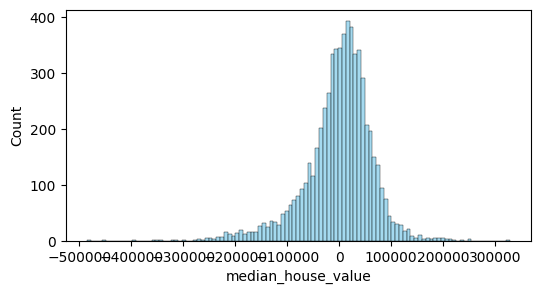

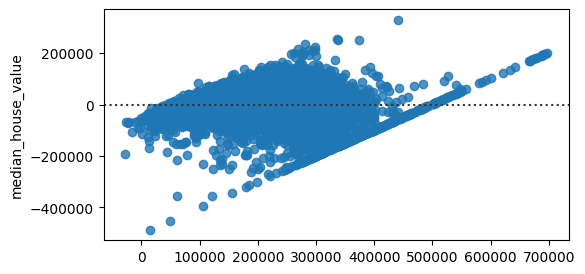

------------------

Resultados do modelo LinearRegression() com validação cruzada:


A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$ 65513.87
O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$ 1556.56
------------------

Avaliando o modelo DecisionTreeRegressor():


A raiz quadrada do erro quadrático médio é: U$ 69886.54
O R2 do modelo é: 0.63
------------------

Os resíduos ficaram distribuídos da seguinte forma:


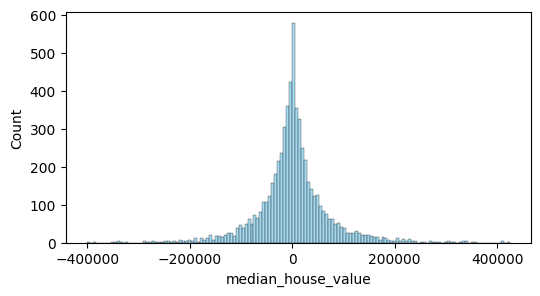

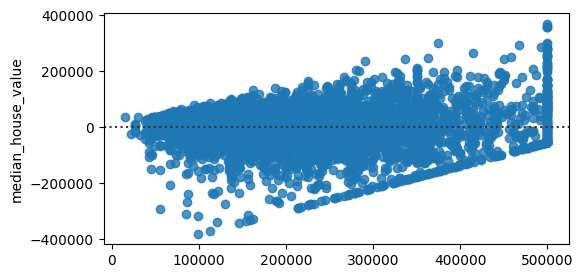

------------------

Resultados do modelo DecisionTreeRegressor() com validação cruzada:


A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$ 70058.25
O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$ 1796.24
------------------

Avaliando o modelo RandomForestRegressor():


A raiz quadrada do erro quadrático médio é: U$ 50169.62
O R2 do modelo é: 0.81
------------------

Os resíduos ficaram distribuídos da seguinte forma:


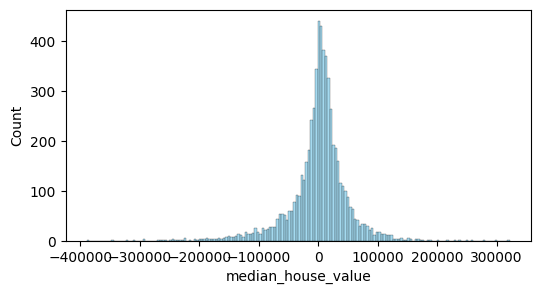

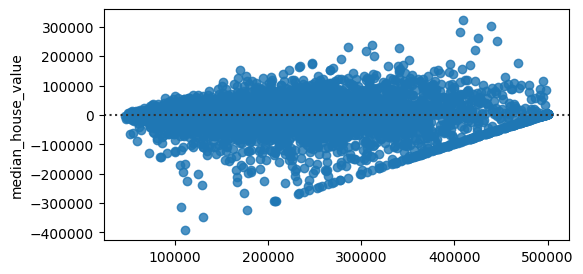

------------------

Resultados do modelo RandomForestRegressor() com validação cruzada:


A média das raízes quadradas dos erros médios encontradas por cross-validation é: U$ 49969.66
O desvio padrão das raízes quadradas do erro médio encontradas por cross-validation é: U$ 650.17
------------------

------------------------
Tabela de resultados:



,Modelo,RMSE,R2,STD_cv.,RMSE_cv
0,Regressão Linear,64603.48,0.68,1556.56,65513.87
1,Árvore de decisão,69886.54,0.63,1796.24,70058.25
2,Floresta Aleatória,50169.62,0.81,650.17,49969.66


In [61]:
## Por fim, vamos rodar tudo com um loop for e armazenar os resultados em uma Dataframe, exibindo-o após todo o processo.

resultados = []
for nome_modelo, modelo in modelos.items():
    rmse, r2, cvscores_std, cvscores_rmse = pipeline(df1, model=modelo)
    resultados.append({'Modelo': nome_modelo,
                       'RMSE': rmse,
                       'R2': r2,
                       'STD_cv.': cvscores_std,
                       'RMSE_cv': cvscores_rmse })
print('------------------------\nTabela de resultados:\n')
pd.DataFrame(resultados)

O sklearn tem seu próprio pipeline, mas eu particularmente prefiro fazer o meu manualmente porque me ajuda a entender melhor o processo por de trás do modelo. Mas também poderíamos ter aplicado essa função do sklearn.

## <b> 5 <span style = 'color:#4148f7'>|</span> APLICANDO O GRIDSEARCHCV NO MELHOR MODELO

Basicamente, o GridSearch, funciona da seguinte forma: 

1. escolhemos qual estimador utilizar (regressão linear, árvore de decisão ou random forest, neste caso);
2. passamos para ele os parâmetros que queremos testar nos nossos modelos, geralmente em forma de dicionário;
3. escolhemos a métrica que será utilizada para avaliar qual é o melhor modelo;
4. definimos o número de validações cruzadas que serão aplicadas.

A ideia é otimizar os parâmetros do melhor modelo para obter melhores resultados.

Vou testar com o RF.


In [62]:
## Definindo os parâmetros do modelo.

rf_params = {
    'n_estimators'     : [10, 50, 100],
    'max_depth'        : [None, 5, 10],
    'min_samples_split': [2, 10, 100, 1000],
    'max_features'     : [1, 2],
    'random_state'     : [None, 42]
}

grid = GridSearchCV(rfreg, rf_params, cv=10, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10], 'max_features': [1, 2],
                         'min_samples_split': [2, 10, 100, 1000],
                         'n_estimators': [10, 50, 100],
                         'random_state': [None, 42]},
             scoring='neg_mean_squared_error')

In [63]:
## Vendo os resultados.

best_param = grid.best_params_
best_score = np.sqrt(-grid.best_score_)
print(f'Os melhores parâmetros encontrados pelo GridSearch foram: \n{best_param}\ne o melhor score, considerando a raiz quadrada do erro quadrático médio foi: U$ {best_score.round(2)}.')
print('\n')
if rfreg_rmse_test>best_score: 
    print('Com isso, melhoramos nosso erro em U$', (rfreg_rmse_test-best_score).round(2))
elif rfreg_rmse_test == best_score:
    print('Sendo assim, nosso erro foi o mesmo que o anterior e não houve melhora nem piora.')
else: 
    print('Sendo assim, nosso erro piorou em U$', (rfreg_rmse_test-best_score).round(2))


Os melhores parâmetros encontrados pelo GridSearch foram: 
{'max_depth': None, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
e o melhor score, considerando a raiz quadrada do erro quadrático médio foi: U$ 51470.95.


Sendo assim, nosso erro piorou em U$ -1470.84


In [7]:
## Aplicando o melhor modelo manualmente:

rfreg = RandomForestRegressor(max_depth=None, max_features=2, min_samples_split=2, n_estimators=100, random_state=42)
modelo = rfreg.fit(x_train, y_train)
yHat_final = modelo.predict(x_test)
rmse_final = np.sqrt(mean_squared_error(y_test, yHat_final)).round(2)
r2_final = r2_score(y_test, yHat_final).round(2)
cvscores_final = cross_val_score(rfreg, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
cvscores_std_final = np.std(np.sqrt(-cvscores_final)).round(2)
cvscores_rmse_final = np.mean(np.sqrt(-cvscores_final)).round(2)


In [65]:
## Adicionando os novos resultados à tabela de resultados.

resultados.append({'Modelo': 'RF otimizado',
                   'RMSE'   : rmse_final,
                   'R2'     : r2_final,
                   'STD_cv.': cvscores_std_final,
                   'RMSE_cv': cvscores_rmse_final })

In [66]:
## Criando um dataframe com os resultados para fazer a comparação final!

df_results = pd.DataFrame(resultados)
df_results

,Modelo,RMSE,R2,STD_cv.,RMSE_cv
0,Regressão Linear,64603.48,0.68,1556.56,65513.87
1,Árvore de decisão,69886.54,0.63,1796.24,70058.25
2,Floresta Aleatória,50169.62,0.81,650.17,49969.66
3,RF otimizado,51116.75,0.80,917.63,51462.77


Note que o modelo de Random Forest com parâmetros otimizados não apresentou resultados melhores do que o modelo aplicado anteriormente.

Isso se deve ao fato de que o parâmetro "random_state" foi fixado no modelo otimizado, enquanto no modelo anterior ele foi deixado no formato padrão "None". Quando o "random_state" não é fixado, o modelo é treinado com diferentes amostras e, portanto, pode apresentar resultados diferentes em cada execução. Isso pode levar a resultados relativamente superiores ou inferiores em comparação ao modelo com o "random_state" fixado.

No entanto, fixar o "random_state" torna o modelo mais consistente e repetível em sua performance, pois sempre partirá da mesma amostra de dados. Portanto, embora o modelo com "random_state" fixado possa apresentar resultados inferiores em relação ao modelo sem "random_state" em algumas execuções, ele é mais confiável em geral.

Dito isso, vamos tomar nosso modelo de RF otimizado como o melhor modelo e salvá-lo.

## <b> 6 <span style = 'color:#4148f7'>|</span> SALVANDO O MODELO FINAL

In [11]:
caminho_modelo = r'C:\Users\Marcilio Duarte\OneDrive\Documents\Projetos\6 - Awari_DS\02_tarefas\projeto_final\data_science\house_prices\code\model\modelo.pickle'
with open(caminho_modelo, 'wb') as arquivo:
    pickle.dump(modelo, arquivo) 

Com isso, temos nosso modelo pronto e armazenado. Daqui, o próximo passo seria fazer o deploy deste modelo em alguma ferramenta (geralmente em nuvem na AWS, Azure ou Google Cloud). Entretanto, como a proposta era apenas o estudo de caso, podemos dizer que o trabalho está concluído! Futuramente, quem sabe, abordamos o passo seguinte.